In [18]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [2]:
def visualize_ir(img, idx=None, cmap='cividis', colorbar=False, save_path=None):
    plt.imshow(img, cmap=cmap)

    if colorbar:
        plt.colorbar()
    
    if not save_path==None:
        #cv2.imwrite(os.path.join(save_path, '{}.png'.format(idx)), img)
        plt.imsave(os.path.join(save_path, '{}.png'.format(idx)), img, cmap='gray')

In [28]:
def expand_greyscale_channels(image):
    image = np.expand_dims(image, -1)
    image = image.repeat(3, axis=-1)
    return image


def crop_center_square(image, im_size=480):
    size=im_size
    height, width = image.shape[:2]
    new_width = new_height = size
    left = (width - new_width) // 2
    top = (height - new_height) // 2
    right = left + new_width
    bottom = top + new_height
    cropped_image = image[top:bottom, left:right]
    return cropped_image

def transform_color(image):
    uniques = np.unique(image)
    
    for idx,elem in enumerate(uniques):
        mask = np.where(image == 1)
        image[mask] = 125
        mask2 = np.where(image == 2)
        image[mask2] = 255
    return image

def preprocess_prediction(image, model_preprocessing):
    image = expand_greyscale_channels(image)

    # create mask of zeros such that preprocessing function works
    random_mask = np.zeros(image.shape)

    sample = model_preprocessing(image=image, mask=random_mask)
    image, _ = sample['image'], sample['mask']
    print(image.shape)
    image = image.astype(np.float32)
    # will add a dimension that replaces batch_size
    image = np.expand_dims(image, axis=0)
    
    return image

In [11]:
def patch_predict(model, image, patch_size, model_preprocessing):
    """
    Predicts on image patches and recombines masks to whole image later.
    
    This function is inspired by
    https://github.com/bnsreenu/python_for_microscopists/blob/master/206_sem_segm_large_images_using_unet_with_custom_patch_inference.py
    
    """

    # initialize mask with zeros
    segm_img = np.zeros(image.shape[:2])
    patch_num=1
    # Iterates through image in steps of patch_size, operates on patches
    for i in range(0, image.shape[0], patch_size):
        for j in range(0, image.shape[1], patch_size):
            single_patch = image[i:i+patch_size, j:j+patch_size]
            single_patch_shape = single_patch.shape[:2]
            single_patch = preprocess_prediction(single_patch, model_preprocessing=model_preprocessing)
            pr_mask = model.predict(single_patch)
            # removes batch dimension and channel dimension by replacing the latter with class with maximum probability value
            pr_mask_processed = np.argmax(pr_mask.squeeze(), axis=2)
            # make mask values visible
            fin = transform_color(pr_mask_processed)
            # recombine to complete image
            segm_img[i:i+single_patch_shape[0], j:j+single_patch_shape[1]] += cv2.resize(fin, single_patch_shape[::-1])
            print("Finished processing patch number ", patch_num, " at position ", i,j)
            patch_num+=1

    return segm_img

In [13]:
import models.segmentation_models_qubvel as sm
from utils.augmentation import get_preprocessing

def predict(img, im_size, weights, pref, backbone='resnet34', train_transfer='imagenet'):
    
    if not im_size==480:
        img = crop_center_square(img, 256)
    
    BACKBONE = backbone
    TRAIN_TRANSFER = train_transfer
    WEIGHTS = weights

    prepro = get_preprocessing(sm.get_preprocessing(BACKBONE))

    model = sm.Unet(BACKBONE, input_shape=(im_size, im_size, 3), classes=3, activation='softmax', encoder_weights=TRAIN_TRANSFER)
    model.load_weights(weights)
    segmented_image = patch_predict(model, img, im_size, model_preprocessing=prepro)
    #segmented_image = segmented_image.squeeze()
    visualize_ir(segmented_image)
    #cv2.imwrite('E:/polar/code/data/ir/predicted/{}.png'.format(pref), segmented_image)

In [14]:
# change this for different images

im = cv2.imread('E:/polar/code/data/ir/predict/20220718_151518_2424.png', 0)
#im = cv2.imread('E:/polar/code/data/ir/predict/20220718_154230_4056.png', 0)

# 256
weights_baseline = 'weights/best_modelprefinal_resnet.h5'
weights_inception = 'weights/best_modelprefinal_inception.h5'
weights_mode0 = 'weights/best_modelaugment_mode0.h5'
weights_mode1 = 'weights/best_modelaugment_mode1.h5'
weights_mode2 = 'weights/best_modelaugment_mode2.h5'
weights_mode4 = 'weights/best_modelaugment_mode4.h5'

weights_32 = 'weights/best_modelbaseline_32.h5'
weights_64 = 'weights/best_modelbaseline_64.h5'
weights_128 = 'weights/best_modelbaseline_128.h5'
weights_480 = 'weights/best_modelbaseline_480.h5'
weights_scratch = 'weights/best_modelscratch.h5'
weights_off2 = 'weights/best_modeloffline2_mode1.h5'
weights_off5 = 'weights/best_modeloffline5_mode1.h5'
weights_weighted = 'weights/best_modelclass_imbalance.h5'

weights_base2 = 'weights/best_modelbaseline2.h5'
weights_vgg = 'weights/best_modelprefinal_vgg.h5'
weights_mode3 = 'weights/best_modelaugment_mode3.h5'

weights_offline20 = 'weights/best_modeloffline20_mode1.h5'

weights_list = [weights_baseline, weights_inception, weights_mode0, weights_mode1, weights_mode2, weights_mode4, weights_32,
                weights_64, weights_128, weights_480, weights_scratch, weights_off2, weights_off5, weights_weighted, weights_base2,
                weights_vgg, weights_mode3, weights_offline20]

(256, 256, 3)
1/1 [==============================] - 3s 3s/step
Finished processing patch number  1  at position  0 0


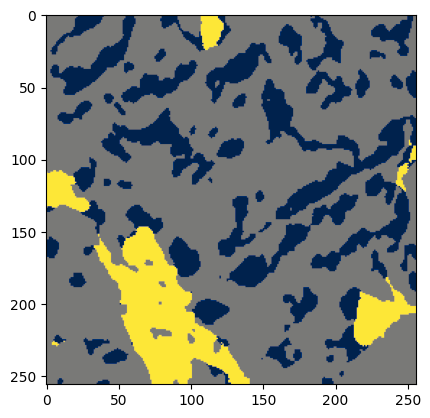

In [38]:
predict(im, 256, weights_list[1], backbone='inceptionv3', train_transfer='imagenet', pref='vgg_2424')

(256, 256, 3)
1/1 [==============================] - 2s 2s/step
Finished processing patch number  1  at position  0 0


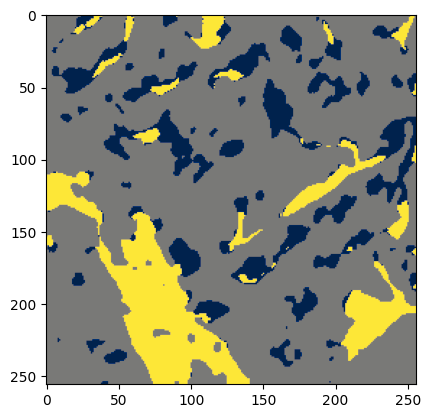

In [35]:
weights_vgg2 = 'weights/best_modelvgg19_foldn1.h5'
predict(im, 256, weights_vgg2, backbone='vgg19', train_transfer='imagenet', pref='vgg_2424')